In [1]:
import sys
sys.executable

'/home/ubuntu/anaconda3/envs/shun/bin/python'

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
from fastai import *
from fastai.vision import *

In [4]:
path = Config.data_path()/'planet'
path.mkdir(parents=True, exist_ok=True)
path

PosixPath('/home/ubuntu/.fastai/data/planet')

In [6]:
! kaggle competitions download -c planet-understanding-the-amazon-from-space -f train-jpg.tar.7z -p {path}  
! kaggle competitions download -c planet-understanding-the-amazon-from-space -f train_v2.csv -p {path}  

 99%|███████████████████████████████████████▌| 593M/600M [00:17<00:00, 42.1MB/s]
100%|████████████████████████████████████████| 600M/600M [00:17<00:00, 35.0MB/s]
  0%|                                                | 0.00/159k [00:00<?, ?B/s]
100%|████████████████████████████████████████| 159k/159k [00:00<00:00, 28.0MB/s]


In [11]:
! unzip -q -n {path}/train_v2.csv.zip -d {path}

In [12]:
! 7za -bd -y -so x {path}/train-jpg.tar.7z | tar xf - -C {path}

In [13]:
df = pd.read_csv(path/'train_v2.csv')
df.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


In [14]:
tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)

In [15]:
np.random.seed(42)
src = (ImageItemList.from_csv(path, 'train_v2.csv', folder='train-jpg', suffix='.jpg')
       .random_split_by_pct(0.2)
       .label_from_df(sep=' '))

In [16]:
data = (src.transform(tfms, size=128)
        .databunch().normalize(imagenet_stats))

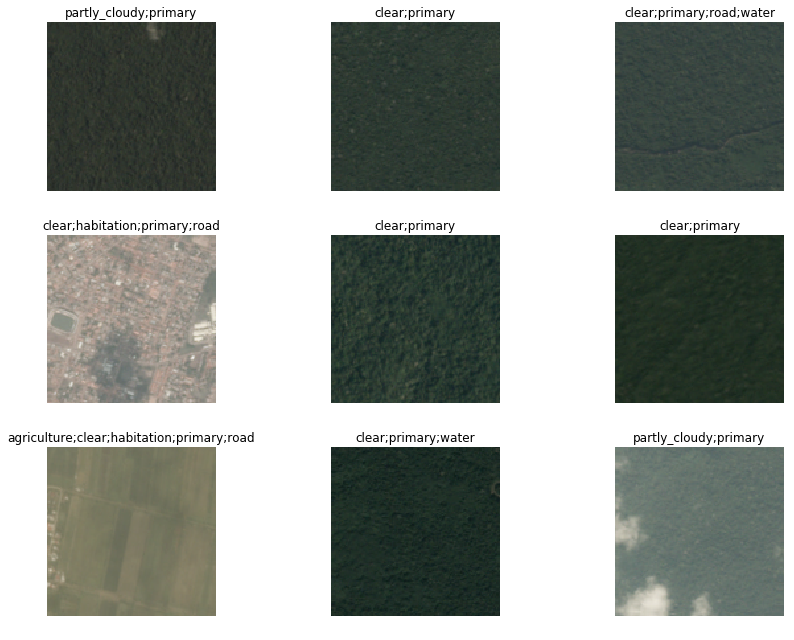

In [17]:
data.show_batch(rows=3, figsize=(12,9))

In [18]:
arch = models.resnet50

In [19]:
acc_02 = partial(accuracy_thresh, thresh=0.2)
f_score = partial(fbeta, thresh=0.2)
learn = create_cnn(data, arch, metrics=[acc_02, f_score])

In [20]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


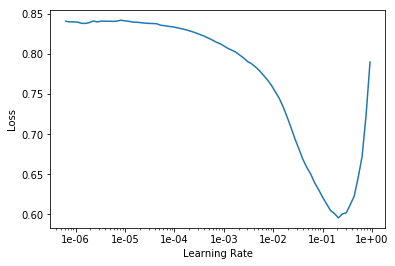

In [21]:
learn.recorder.plot()

In [22]:
lr = 0.01

In [23]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta
1,0.125794,0.111512,0.940660,0.900505
2,0.108333,0.096209,0.951931,0.918037
3,0.102871,0.092419,0.957410,0.920080
4,0.096453,0.088081,0.956320,0.923393
5,0.093322,0.087053,0.956117,0.924104


In [24]:
learn.save('stage-1-rn50')

In [25]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


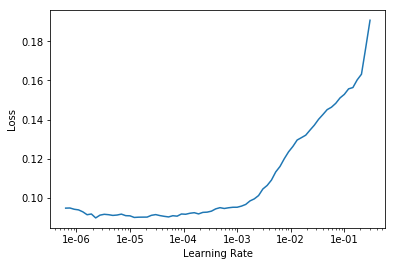

In [26]:
learn.lr_find()
learn.recorder.plot()

In [27]:
learn.fit_one_cycle(5, slice(1e-5, lr/5))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta
1,0.098544,0.090711,0.953086,0.919101
2,0.096600,0.089471,0.956560,0.921735
3,0.092160,0.085981,0.959678,0.925165
4,0.088043,0.083154,0.958028,0.927025
5,0.079758,0.082884,0.958478,0.927875


In [28]:
learn.save('stage-2-rn50')

In [29]:
data = (src.transform(tfms, size=256)
        .databunch().normalize(imagenet_stats))

learn.data = data
data.train_ds[0][0].shape

torch.Size([3, 256, 256])

In [30]:
learn.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


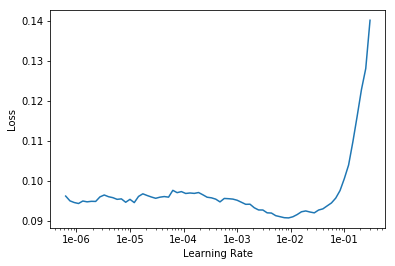

In [31]:
learn.lr_find()
learn.recorder.plot()

In [32]:
lr=1e-2/2

In [33]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta
1,0.088146,0.084652,0.957657,0.927089
2,0.089362,0.084330,0.958704,0.925624
3,0.085765,0.084073,0.958624,0.927380
4,0.082091,0.081053,0.958093,0.930358
5,0.079655,0.081338,0.958820,0.930063


In [34]:
learn.save('stage-1-256-rn50')

In [35]:
learn.unfreeze()

In [36]:
learn.fit_one_cycle(5, slice(1e-5, lr/5))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta
1,0.082399,0.084204,0.958486,0.926164
2,0.083780,0.084303,0.959060,0.927994
3,0.082349,0.081794,0.956902,0.930469
4,0.078189,0.080589,0.958907,0.930786
5,0.075270,0.080828,0.959735,0.931372


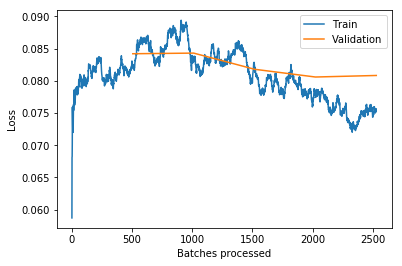

In [37]:
learn.recorder.plot_losses()

In [38]:
learn.save('stage-2-256-rn50')